In [6]:
import sys
from pathlib import Path

# Add the path to the 'projects.tii_scqt_utils.monitor' module
module_path = Path("/home/lauramartinez/my_env/QPU147-monitoring/projects/")
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [7]:
# import sys

# # Adjust the module_path to include the 'tii_scqt_utils' subdirectory
# corrected_module_path = module_path / "monitor"

# # Add the corrected_module_path to sys.path if not already present
# if str(corrected_module_path) not in sys.path:
# 	sys.path.append(str(corrected_module_path))

# Import the Post_processing module
from tii_scqt_utils import monitor
# from projects.tii_scqt_utils.monitor import Post_processing --- IGNORE ---
pp = Post_processing(csv_names=csv_file_names, csv_dir=str(DATASET_DIR), save_filename="merged_coherence_data.csv")
fig, data = pp.plot()	

ModuleNotFoundError: No module named 'tii_scqt_utils'

In [ ]:
# Optimized post-processing with session-based plotting and stats box (date + hour on X-axis)

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates

# -------------------------------
# Path configuration and CSV files
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSV files to read (INPUT)
csv_file_names = [
    #Q0
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv",
    # "20251022_Q4_coherence_monitoring_log.csv"
]

csv_paths = [DATASET_DIR / name for name in csv_file_names]

if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")

# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

data = pd.concat(dfs, ignore_index=True)

# -------------------------------
# Clean and process data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)

# Gap detection
GAP_THRESHOLD_MINUTES = 15
data["TimeDiff"] = data["Timestamp"].diff().dt.total_seconds()
data["Gap"] = data["TimeDiff"] > (GAP_THRESHOLD_MINUTES * 60)

# Save combined dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
data.to_csv(output_csv_path, index=False)
print(f"\n✅ Combined data saved to {output_csv_path}")

# -------------------------------
# Plotting options
times_to_plot = ["T1", "T2*", "T2E"]
colors = {"T1": "blue", "T2*": "orange", "T2E": "green"}

# Filter out extreme values if desired (optional)
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None}  # thresholds in μs
data_filtered = data.copy()
datos_incoherentes = []

mask = pd.Series(True, index=data_filtered.index)
for t in times_to_plot:
    if MAX_VALUES[t] is not None:
        t_values = data_filtered[t]*1e6  # convert to μs
        mask &= t_values <= MAX_VALUES[t]

datos_incoherentes.append(data_filtered[~mask])
data_filtered = data_filtered[mask]
print(f"✅ Rows kept after filtering: {len(data_filtered)}")
print(f"⚠️ Rows removed due to exceeding thresholds: {len(pd.concat(datos_incoherentes))}")

# -------------------------------
# Session-based plotting (continuous blocks without large gaps)
data_filtered = data_filtered.sort_values("Timestamp").reset_index(drop=True)
data_filtered['SessionID'] = data_filtered['Gap'].cumsum()
session_ids = data_filtered['SessionID'].unique()

for session in session_ids:
    df_session = data_filtered[data_filtered['SessionID'] == session].copy()
    
    # Create figure with 2 subplots: scatter + stats box
    fig, (ax_scatter, ax_box) = plt.subplots(
        2, 1, figsize=(12, 7),
        gridspec_kw={'height_ratios': [4, 1]},
        constrained_layout=True
    )
    
    # --- Scatter plot ---
    for t in times_to_plot:
        values_us = df_session[t] * 1e6
        ax_scatter.scatter(df_session["Timestamp"], values_us, s=25, color=colors[t], label=t)
    
    # X-axis: show date + hour
    ax_scatter.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax_scatter.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax_scatter.get_xticklabels(), rotation=45, ha='right')
    
    ax_scatter.set_title(f"Coherence Time Monitoring - Session {session}")
    ax_scatter.set_xlabel("Date & Time")
    ax_scatter.set_ylabel("Coherence Times (μs)")
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend(fontsize=8, loc="upper right")
    
    # --- Statistics box ---
    stats_text = ""
    for t in times_to_plot:
        values_us = df_session[t] * 1e6
        mean_val = values_us.mean()
        std_val = values_us.std()
        min_val = values_us.min()
        max_val = values_us.max()
        stats_text += (
            f"{t} → mean={mean_val:.2f} μs, std={std_val:.2f} μs, "
            f"min={min_val:.2f} μs, max={max_val:.2f} μs\n"
        )
    
    ax_box.axis("off")
    ax_box.text(
        0.5, 0.5, stats_text.strip(),
        ha='center', va='center',
        fontsize=10,
        family='monospace',
        bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6')
    )
    
    plt.show()


: 

In [4]:
# Histogram of coherence times from merged dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------
# CSV configuration
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSVs to merge
csv_file_names = [
    #Q0
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv"
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    "20251016_Q4_coherence_monitoring_log.csv"
]

csv_paths = [DATASET_DIR / name for name in csv_file_names]

# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        # Filter invalid values (NaN or <= 0)
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

# Merge into one dataset
merged_data = pd.concat(dfs, ignore_index=True)

# Convert timestamps and sort
merged_data["Timestamp"] = pd.to_datetime(merged_data["Timestamp"])
merged_data = merged_data.sort_values("Timestamp").reset_index(drop=True)

# Optional: filter extreme values
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None}  # thresholds in µs
for col, max_val in MAX_VALUES.items():
    if max_val is not None:
        merged_data = merged_data[merged_data[col]*1e6 <= max_val]

# Save merged dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
merged_data.to_csv(output_csv_path, index=False)
print(f"\n✅ Merged dataset saved to {output_csv_path}")

# -------------------------------
# Parameters to plot histograms
params = {
    'T1':  {'column': 'T1', 'label': 'T1 (μs)', 'title': 'T1 Distribution - Q4'},
    'T2*': {'column': 'T2*', 'label': 'T2* (μs)', 'title': 'T2* Distribution - Q4'},
    'T2 Echo': {'column': 'T2E', 'label': 'T2 Echo (μs)', 'title': 'T2 Echo Distribution - Q4'},
}

# -------------------------------
# Histogram plotting with normal fit
for name, info in params.items():
    values = merged_data[info['column']].dropna() * 1e6  # convert to µs
    
    if values.empty:
        print(f"No valid data for {name}, skipping.")
        continue
    
    # Calculate mean and std manually (without scipy)
    mu = np.mean(values)
    std = np.std(values)
    
    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(values, bins=15, density=True, alpha=0.6,
             color='orchid', edgecolor='darkmagenta', label='Histogram (density)')
    
    # Normal distribution curve
    x = np.linspace(values.min(), values.max(), 200)
    pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/std)**2)
    plt.plot(x, pdf, 'g--', linewidth=2, label=f'Normal fit\nμ={mu:.2f} µs\nσ={std:.2f} µs')
    
    # Styling
    plt.title(info['title'])
    plt.xlabel(info['label'])
    plt.ylabel('Frequency of Ocurrence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'pandas'

In [3]:
# Optimized post-processing for Coherence Time Monitoring (Cleaned Version)

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
import numpy as np # Se mantiene por si se usa en otras partes del código

# -------------------------------
# Path configuration and CSV files
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSV files to read (INPUT)
csv_file_names = [
    #Q0
    "20251002_Q0_coherence_monitoring_log.csv",
    "20251003_Q0_coherence_monitoring_log.csv",
    "20251004_1_Q0_coherence_monitoring_log.csv",
    "20251004_2_Q0_coherence_monitoring_log.csv",
    "20251005_Q0_coherence_monitoring_log.csv",
    "20251006_1_Q0_coherence_monitoring_log.csv",
    "20251006_2_Q0_coherence_monitoring_log.csv",
    "20251006_3_Q0_coherence_monitoring_log.csv",
    "20251006_4_Q0_coherence_monitoring_log.csv",
    "20251007_Q0_coherence_monitoring_log.csv",
    "20251017_Q0_coherence_monitoring_log.csv"
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv"
]

csv_paths = [DATASET_DIR / name for name in csv_file_names]

qubit = "Q4"  # Cambiar según el qubit que se esté analizando

if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")

# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        
        # NOTA IMPORTANTE: Se han eliminado las líneas de simulación de columnas de error.
        
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

data = pd.concat(dfs, ignore_index=True)

# -------------------------------
# Clean and process data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)


# -------CALCULATE MONITORING HOURS-----------------------
# Clean and process data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)

# -------------------------------
# AÑADIR CÁLCULO DE TIEMPO TOTAL MONITOREADO
# Calculamos el delta entre el último y el primer timestamp.
total_monitoring_time = data["Timestamp"].iloc[-1] - data["Timestamp"].iloc[0]
total_hours = total_monitoring_time.total_seconds() / 3600

# Imprimir el resultado para el log
print(f"**Tiempo total monitoreado (Qubit {qubit}): {total_hours:.2f} horas**")

# -------------------------------


# Gap detection
GAP_THRESHOLD_MINUTES = 15
data["TimeDiff"] = data["Timestamp"].diff().dt.total_seconds()
data["Gap"] = data["TimeDiff"] > (GAP_THRESHOLD_MINUTES * 60)

# Save combined dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
data.to_csv(output_csv_path, index=False)
print(f"\n✅ Combined data saved to {output_csv_path}")

# -------------------------------
# Plotting options
times_to_plot = ["T1", "T2*", "T2E"]
colors = {"T1": "blue", "T2*": "orange", "T2E": "green"}

# Filter out extreme values if desired (optional)
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None}  # thresholds in μs
data_filtered = data.copy()
datos_incoherentes = []

mask = pd.Series(True, index=data_filtered.index)
for t in times_to_plot:
    if MAX_VALUES[t] is not None:
        t_values = data_filtered[t]*1e6  # convert to μs
        mask &= t_values <= MAX_VALUES[t]

datos_incoherentes.append(data_filtered[~mask])
data_filtered = data_filtered[mask]
print(f"✅ Rows kept after filtering: {len(data_filtered)}")
print(f"⚠️ Rows removed due to exceeding thresholds: {len(pd.concat(datos_incoherentes))}")

# -------------------------------
# Session-based plotting (continuous blocks without large gaps)
data_filtered = data_filtered.sort_values("Timestamp").reset_index(drop=True)
data_filtered['SessionID'] = data_filtered['Gap'].cumsum()
session_ids = data_filtered['SessionID'].unique()

for session in session_ids:
    df_session = data_filtered[data_filtered['SessionID'] == session].copy()
    
    # Create figure with 2 subplots: scatter + stats box
    fig, (ax_scatter, ax_box) = plt.subplots(
        2, 1, figsize=(12, 7),
        gridspec_kw={'height_ratios': [4, 1]},
        constrained_layout=True
    )
    
    # --- Scatter plot (Con Bandas de STD y Leyenda con Media) ---
    stats_data = {} # Diccionario para guardar estadísticas de la sesión
    for t in times_to_plot:
        
        values_us = df_session[t] * 1e6
        
        mean_val = values_us.mean()
        std_val = values_us.std()
        
        # 1. Almacenar estadísticas
        stats_data[t] = {
            'mean': mean_val, 
            'std': std_val,
            'min': values_us.min(), 
            'max': values_us.max()
        }

        # 2. Plotear Puntos (Leyenda Mejorada: incluye la Media)
        # Usamos LaTeX para 'mu' ($\mu$s)
        label_text = f"{t}"
        ax_scatter.scatter(
            df_session["Timestamp"], 
            values_us, 
            s=25, 
            color=colors[t], 
            label=label_text
        )
        
        # 3. Añadir Banda de Desviación Estándar (STD de la sesión)
        ax_scatter.axhspan(
            mean_val - std_val, mean_val + std_val,
            color=colors[t], alpha=0.15, 
            label=None # NO añadir esta banda a la leyenda
        )
    
    # X-axis: show date + hour
    ax_scatter.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax_scatter.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax_scatter.get_xticklabels(), rotation=45, ha='right')
    
    ax_scatter.set_title(f"Coherence Time Monitoring - Session {session} - Qubit {qubit}")
    ax_scatter.set_xlabel("Date & Time")
    ax_scatter.set_ylabel("Coherence Times ($\\mu$s)") # Uso de LaTeX para mu
    ax_scatter.grid(True, alpha=0.3)
    ax_scatter.legend(fontsize=9, loc="upper right")
    
    # --- Statistics box (Limpia: solo STD, Min, Max) ---
    stats_text = ""
    for t in times_to_plot:
        data = stats_data[t]
        
        # Incluimos STD, Min, y Max
        stats_text += (
            f"{t} $\\rightarrow$ std={data['std']:.2f} $\\mu$s, "
            f"mean={data['mean']:.2f} $\\mu$s, "
            f"min={data['min']:.2f} $\\mu$s, max={data['max']:.2f} $\\mu$s\n"
        )
    
    ax_box.axis("off")
    ax_box.text(
        0.5, 0.5, stats_text.strip(),
        ha='center', va='center',
        fontsize=10,
        family='monospace',
        bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6')
    )
    
    plt.show()

ModuleNotFoundError: No module named 'pandas'

✅ File read: 20251002_Q0_coherence_monitoring_log.csv
✅ File read: 20251003_Q0_coherence_monitoring_log.csv
✅ File read: 20251004_1_Q0_coherence_monitoring_log.csv
✅ File read: 20251004_2_Q0_coherence_monitoring_log.csv
✅ File read: 20251005_Q0_coherence_monitoring_log.csv
✅ File read: 20251006_1_Q0_coherence_monitoring_log.csv
✅ File read: 20251006_2_Q0_coherence_monitoring_log.csv
✅ File read: 20251006_3_Q0_coherence_monitoring_log.csv
✅ File read: 20251006_4_Q0_coherence_monitoring_log.csv
✅ File read: 20251007_Q0_coherence_monitoring_log.csv
✅ File read: 20251017_Q0_coherence_monitoring_log.csv

✅ Merged dataset saved to /home/lauramartinez/my_env/QPU147-monitoring/datasets/merged_coherence_data.csv


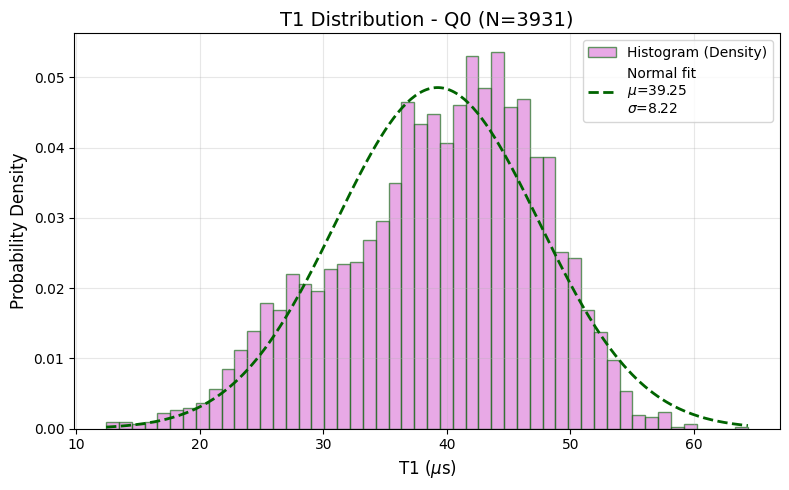

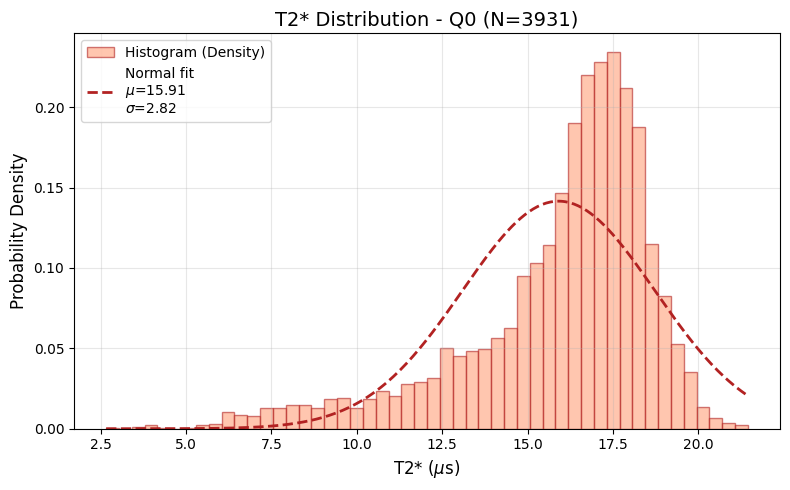

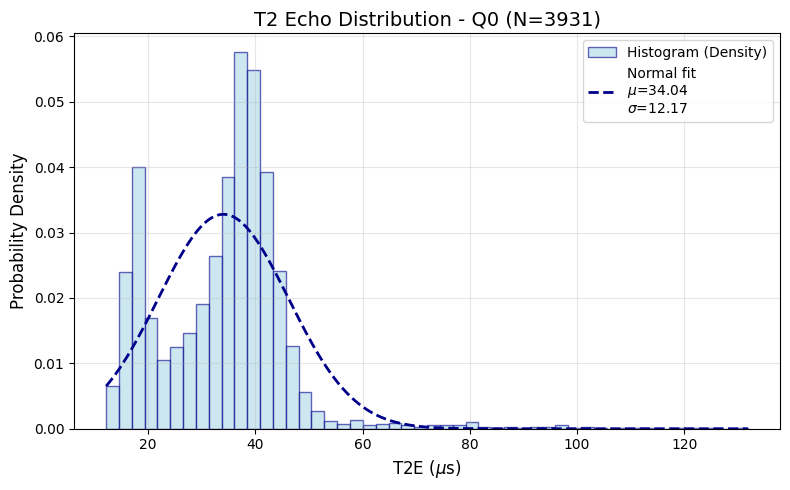

In [13]:
# Histogram of coherence times from merged dataset - Gemini
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# No se necesita importar scipy.stats ya que usamos el ajuste Normal de numpy

# -------------------------------
# CSV configuration
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSVs to merge
csv_file_names = [
    #Q0
    "20251002_Q0_coherence_monitoring_log.csv",
    "20251003_Q0_coherence_monitoring_log.csv",
    "20251004_1_Q0_coherence_monitoring_log.csv",
    "20251004_2_Q0_coherence_monitoring_log.csv",
    "20251005_Q0_coherence_monitoring_log.csv",
    "20251006_1_Q0_coherence_monitoring_log.csv",
    "20251006_2_Q0_coherence_monitoring_log.csv",
    "20251006_3_Q0_coherence_monitoring_log.csv",
    "20251006_4_Q0_coherence_monitoring_log.csv",
    "20251007_Q0_coherence_monitoring_log.csv",
    "20251017_Q0_coherence_monitoring_log.csv"
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv"
]

csv_paths = [DATASET_DIR / name for name in csv_file_names]

# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        # Filter invalid values (NaN or <= 0)
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

# Merge into one dataset
merged_data = pd.concat(dfs, ignore_index=True)

# Convert timestamps and sort
merged_data["Timestamp"] = pd.to_datetime(merged_data["Timestamp"])
merged_data = merged_data.sort_values("Timestamp").reset_index(drop=True)

# Optional: filter extreme values
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None}  # thresholds in µs
for col, max_val in MAX_VALUES.items():
    if max_val is not None:
        merged_data = merged_data[merged_data[col]*1e6 <= max_val]

# Save merged dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
merged_data.to_csv(output_csv_path, index=False)
print(f"\n✅ Merged dataset saved to {output_csv_path}")

# -------------------------------
# Parameters to plot histograms - CONTROL DE COLORES
params = {
    'T1': {'column': 'T1', 'label': 'T1 ($\\mu$s)', 'title': 'T1 Distribution - Q0', 
           'fit_color': 'darkgreen',   # Color de la curva de ajuste y borde de las barras
           'hist_color': 'orchid'},    # Color de relleno de las barras
           
    'T2*': {'column': 'T2*', 'label': 'T2* ($\\mu$s)', 'title': 'T2* Distribution - Q0', 
            'fit_color': 'firebrick', 
            'hist_color': 'lightsalmon'},
            
    'T2 Echo': {'column': 'T2E', 'label': 'T2E ($\\mu$s)', 'title': 'T2 Echo Distribution - Q0', 
                'fit_color': 'darkblue', 
                'hist_color': 'lightblue'},
}

# -------------------------------
# Histogram plotting with STANDARD NORMAL FIT
for name, info in params.items():
    values_raw = merged_data[info['column']].dropna()
    values_us = values_raw * 1e6  # convert to µs
    
    if values_us.empty:
        print(f"No valid data for {name}, skipping.")
        continue
    
    N = len(values_us)
    
    # --- 1. Ajuste Normal (Gaussiana) simple ---
    mu = np.mean(values_us)
    std = np.std(values_us)
    
    # Leyenda de la curva: sin unidades en mu/sigma
    fit_label = f'Normal fit\n$\\mu$={mu:.2f}\n$\\sigma$={std:.2f}'

    # -------------------------------
    # Plotting
    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    
    # Histogram - USANDO LAS NUEVAS CLAVES DE COLOR
    ax.hist(
        values_us, 
        bins=50, 
        density=True, 
        alpha=0.6,
        color=info['hist_color'],    # Color de relleno
        edgecolor=info['fit_color'], # Color del borde
        label='Histogram (Density)'
    )
    
    # PDF Curve (Función de Densidad de Probabilidad Normal)
    x = np.linspace(values_us.min(), values_us.max(), 300)
    pdf_fitted = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/std)**2)
        
    ax.plot(x, pdf_fitted, '--', color=info['fit_color'], linewidth=2, label=fit_label)
    
    # --- Styling ---
    
    # Título (incluye N)
    ax.set_title(f"{info['title']} (N={N})", fontsize=14)
    
    # Ejes (Uso de LaTeX y etiqueta Y mejorada)
    ax.set_xlabel(info['label'], fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    
    # Leyenda
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Mostrar en pantalla
    plt.show()

✅ File read: 20251028_coherence_monitoring_log_q2.csv

✅ Merged dataset saved to /home/lauramartinez/my_env/QPU147-monitoring/datasets/merged_coherence_data.csv


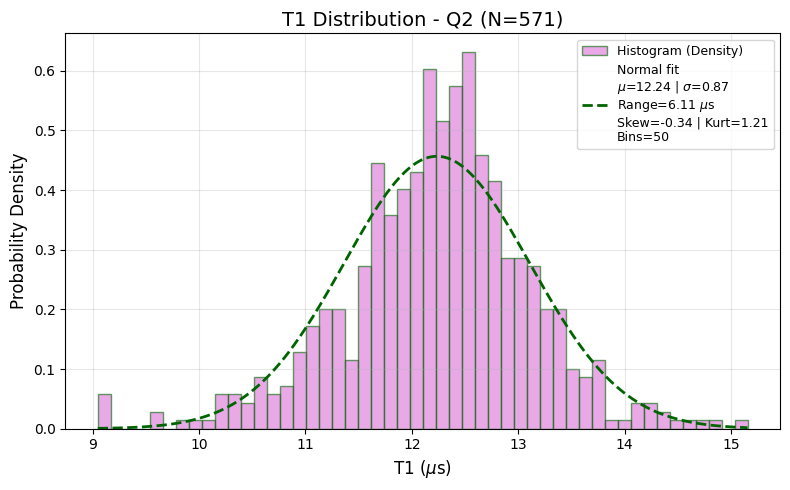


--- Análisis Estadístico para T1 (N=571) ---
1. Central Tendency: Mean (μ) = 12.24 µs | Median = 12.30 µs
2. Spread: Std Dev (σ) = 0.87 µs | Range = 6.11 µs
3. Shape: Skewness = -0.34 | Kurtosis (Excess) = 1.21


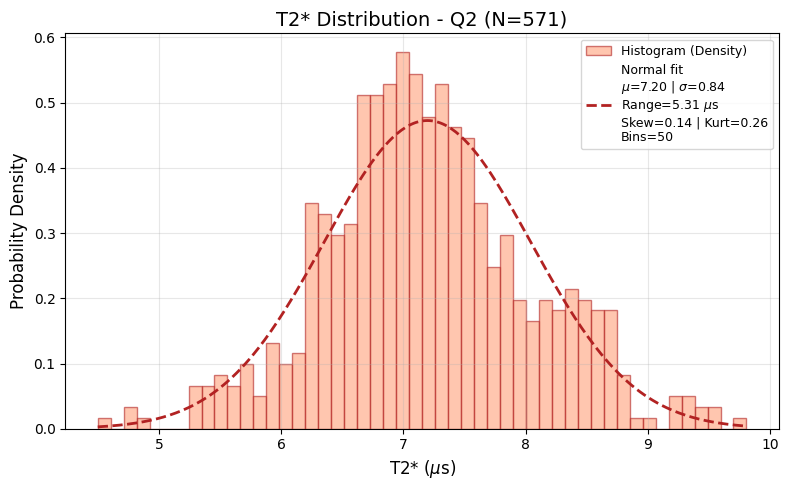


--- Análisis Estadístico para T2* (N=571) ---
1. Central Tendency: Mean (μ) = 7.20 µs | Median = 7.14 µs
2. Spread: Std Dev (σ) = 0.84 µs | Range = 5.31 µs
3. Shape: Skewness = 0.14 | Kurtosis (Excess) = 0.26


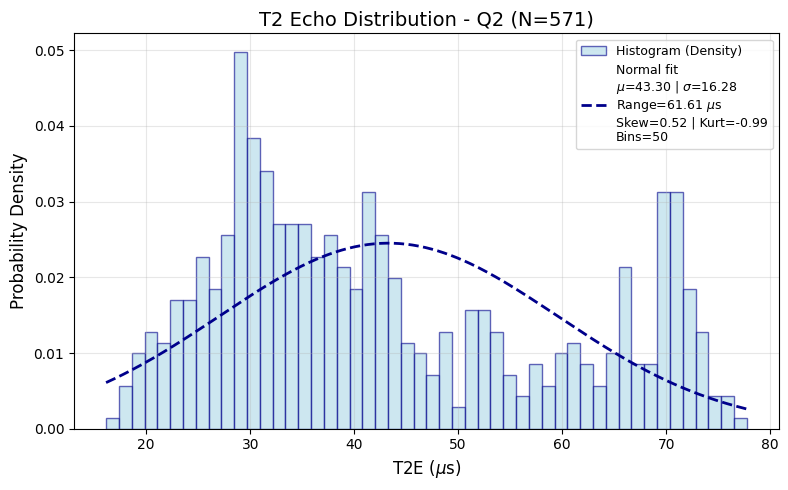


--- Análisis Estadístico para T2 Echo (N=571) ---
1. Central Tendency: Mean (μ) = 43.30 µs | Median = 38.98 µs
2. Spread: Std Dev (σ) = 16.28 µs | Range = 61.61 µs
3. Shape: Skewness = 0.52 | Kurtosis (Excess) = -0.99


In [29]:
# 20/10/2025
# Histogram of coherence times from merged dataset - FINAL SCRIPT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import skew, kurtosis # IMPORTANTE: Necesario para Skewness y Kurtosis

# -------------------------------
# CSV configuration
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# List of CSVs to merge
csv_file_names = [
    #Q0 (Ajusta la lista según el qubit que quieras analizar)
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv",
    # "20251007_Q0_coherence_monitoring_log.csv",
    # "20251017_Q0_coherence_monitoring_log.csv"
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv",
    # "20251022_Q4_coherence_monitoring_log.csv"
    #Q2
    "20251028_coherence_monitoring_log_q2.csv"

]

csv_paths = [DATASET_DIR / name for name in csv_file_names]

# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        # Nota: Asegúrate de que el path sea correcto y el archivo exista
        df = pd.read_csv(f, dtype={'Timestamp': str})
        # Filter invalid values (NaN or <= 0)
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid data after filtering.")

# Merge into one dataset
merged_data = pd.concat(dfs, ignore_index=True)

# Convert timestamps and sort
merged_data["Timestamp"] = pd.to_datetime(merged_data["Timestamp"])
merged_data = merged_data.sort_values("Timestamp").reset_index(drop=True)

# Optional: filter extreme values - EXPLICACIÓN EN PUNTO 2
# Filtra valores por encima del umbral definido para evitar outliers que distorsionen μ y σ
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None}  # thresholds in µs
for col, max_val in MAX_VALUES.items():
    if max_val is not None:
        merged_data = merged_data[merged_data[col]*1e6 <= max_val]

# Save merged dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
merged_data.to_csv(output_csv_path, index=False)
print(f"\n✅ Merged dataset saved to {output_csv_path}")

# -------------------------------
# Parameters to plot histograms - CONTROL DE COLORES y BINS
params = {
    'T1': {'column': 'T1', 'label': 'T1 ($\\mu$s)', 'title': 'T1 Distribution - Q2', 
           'fit_color': 'darkgreen',   
           'hist_color': 'orchid',
           'num_bins': 50}, # <--- Número fijo de bins
           
    'T2*': {'column': 'T2*', 'label': 'T2* ($\\mu$s)', 'title': 'T2* Distribution - Q2', 
            'fit_color': 'firebrick', 
            'hist_color': 'lightsalmon',
            'num_bins': 50}, # <--- Número fijo de bins
            
    'T2 Echo': {'column': 'T2E', 'label': 'T2E ($\\mu$s)', 'title': 'T2 Echo Distribution - Q2', 
                'fit_color': 'darkblue', 
                'hist_color': 'lightblue',
                'num_bins': 50}, # <--- Número fijo de bins
}

# -------------------------------
# Histogram plotting with STANDARD NORMAL FIT
for name, info in params.items():
    values_raw = merged_data[info['column']].dropna()
    values_us = values_raw * 1e6 # convert to µs
    
    if values_us.empty:
        print(f"No valid data for {name}, skipping.")
        continue
    
    N = len(values_us)
    
    # --- 1. Análisis Descriptivo Completo ---
    mu = np.mean(values_us)
    std = np.std(values_us)
    median = np.median(values_us)
    
    # Métrica de Spread y Shape
    data_range = values_us.max() - values_us.min() 
    data_skew = skew(values_us) # Asimetría
    data_kurt = kurtosis(values_us) # Curtosis (Exceso)
    
    # Leyenda con TODAS las métricas
    fit_label = (
        f'Normal fit\n'
        f'$\\mu$={mu:.2f} | $\\sigma$={std:.2f}\n'
        f'Range={data_range:.2f} $\\mu$s\n'
        f'Skew={data_skew:.2f} | Kurt={data_kurt:.2f}\n'
        f'Bins={info["num_bins"]}'
    )

    # -------------------------------
    # Plotting
    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    
    # Histogram - USANDO LOS BINS FIJOS
    ax.hist(
        values_us, 
        bins=info["num_bins"], # <--- Número fijo de bins
        density=True, 
        alpha=0.6,
        color=info['hist_color'], 
        edgecolor=info['fit_color'], 
        label='Histogram (Density)'
    )
    
    # PDF Curve (Función de Densidad de Probabilidad Normal)
    x = np.linspace(values_us.min(), values_us.max(), 300)
    pdf_fitted = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/std)**2)
        
    ax.plot(x, pdf_fitted, '--', color=info['fit_color'], linewidth=2, label=fit_label)
    
    # --- Styling ---
    ax.set_title(f"{info['title']} (N={N})", fontsize=14)
    ax.set_xlabel(info['label'], fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend(fontsize=9, loc='best') # Hacemos la leyenda más pequeña y la ubicamos mejor
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Mostrar en pantalla
    plt.show() 
    
    # --- Análisis Estadístico en Consola (para informes) ---
    print(f"\n--- Análisis Estadístico para {name} (N={N}) ---")
    print(f"1. Central Tendency: Mean (μ) = {mu:.2f} µs | Median = {median:.2f} µs")
    print(f"2. Spread: Std Dev (σ) = {std:.2f} µs | Range = {data_range:.2f} µs")
    print(f"3. Shape: Skewness = {data_skew:.2f} | Kurtosis (Excess) = {data_kurt:.2f}")

✅ File read: 20251028_coherence_monitoring_log_q2.csv

✅ Combined data saved to /home/lauramartinez/my_env/QPU147-monitoring/datasets/merged_coherence_data.csv
✅ Rows kept after filtering: 571
⚠️ Rows removed due to exceeding thresholds: 0


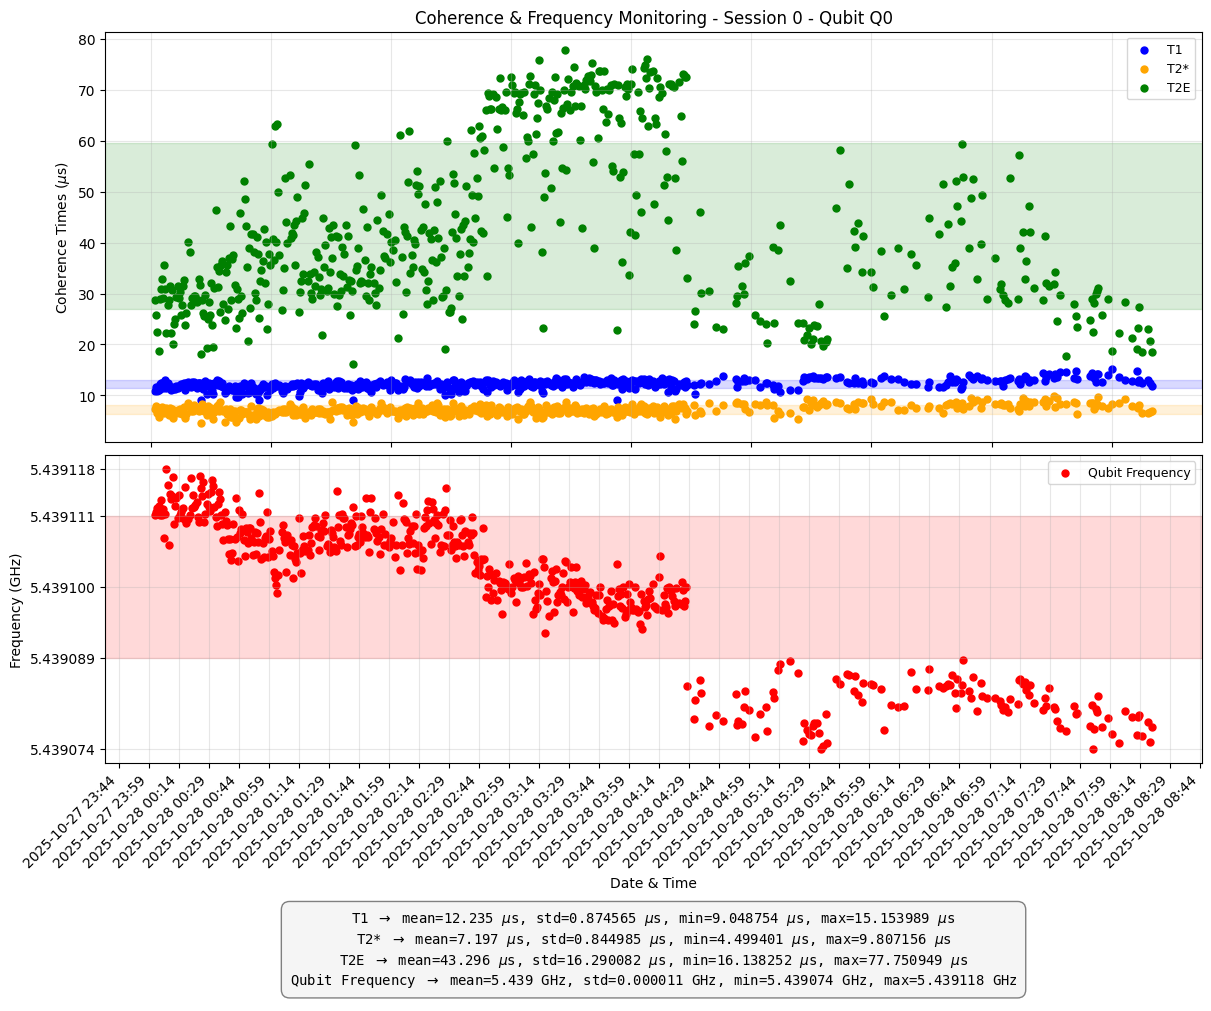

In [27]:

 
# Optimized post-processing for Coherence Time and Frequency Monitoring (Series Temporal)
 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
import numpy as np
 
# -------------------------------
# Path configuration and CSV files
DATASET_DIR = Path("/home/lauramartinez/my_env/QPU147-monitoring/datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)
 
# List of CSV files to read (INPUT)
csv_file_names = [
    #Q0
    # "20251002_Q0_coherence_monitoring_log.csv",
    # "20251003_Q0_coherence_monitoring_log.csv",
    # "20251004_1_Q0_coherence_monitoring_log.csv",
    # "20251004_2_Q0_coherence_monitoring_log.csv",
    # "20251005_Q0_coherence_monitoring_log.csv",
    # "20251006_1_Q0_coherence_monitoring_log.csv",
    # "20251006_2_Q0_coherence_monitoring_log.csv",
    # "20251006_3_Q0_coherence_monitoring_log.csv",
    # "20251006_4_Q0_coherence_monitoring_log.csv"
    # "20251007_Q0_coherence_monitoring_log.csv",
    # "20251017_Q0_coherence_monitoring_log.csv",
    # "20251019_Q0_coherence_monitoring_log.csv",
    #Q4
    # "20251010_Q4_coherence_monitoring_log.csv",
    # "20251013_Q4_coherence_monitoring_log.csv",
    # "20251014_1_Q4_coherence_monitoring_log.csv",
    # "20251014_2_Q4_coherence_monitoring_log.csv",
    # "20251015_Q4_coherence_monitoring_log.csv",
    # "20251016_Q4_coherence_monitoring_log.csv",
    # "20251022_Q4_coherence_monitoring_log.csv",
    #Q2
    "20251028_coherence_monitoring_log_q2.csv"
]
 
csv_paths = [DATASET_DIR / name for name in csv_file_names]
 
qubit = "Q0" # Asegúrate de que este valor sea correcto (Q0 en el ejemplo).
 
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")
 
# -------------------------------
# Read and combine CSVs
dfs = []
for f in csv_paths:
    try:
        df = pd.read_csv(f, dtype={'Timestamp': str})
        df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
        dfs.append(df)
        print(f"✅ File read: {f.name}")
    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")
 
if not dfs:
    raise ValueError("No valid data after filtering.")
 
data = pd.concat(dfs, ignore_index=True)
 
# -------------------------------
# Clean and process data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values("Timestamp").reset_index(drop=True)
 
# Gap detection
GAP_THRESHOLD_MINUTES = 15
data["TimeDiff"] = data["Timestamp"].diff().dt.total_seconds()
data["Gap"] = data["TimeDiff"] > (GAP_THRESHOLD_MINUTES * 60)
 
# Save combined dataset
output_csv_path = DATASET_DIR / "merged_coherence_data.csv"
data.to_csv(output_csv_path, index=False)
print(f"\n✅ Combined data saved to {output_csv_path}")
 
# -------------------------------
# Plotting options
# DEFINICIÓN DE MÉTRICAS Y ESCALAS
coherence_metrics = ["T1", "T2*", "T2E"]
frequency_metric = "Qubit Frequency" # NOMBRE DE COLUMNA CORREGIDO
metrics_to_plot = coherence_metrics + [frequency_metric]
 
# Colores
colors = {"T1": "blue", "T2*": "orange", "T2E": "green", "Qubit Frequency": "red"}
 
# Unidades de conversión (segundos a µs, Hz a GHz)
unit_conversion = {"T1": 1e6, "T2*": 1e6, "T2E": 1e6, "Qubit Frequency": 1e-9}
# Etiqueta de eje Y
y_labels = {"T1": "Coherence Times ($\\mu$s)", "Qubit Frequency": "Frequency (GHz)"}
 
 
# Filter out extreme values (optional)
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None, "Qubit Frequency": None} 
data_filtered = data.copy()
datos_incoherentes = []
 
mask = pd.Series(True, index=data_filtered.index)
for t in metrics_to_plot:
    if MAX_VALUES[t] is not None:
        # Convertir y filtrar
        t_values = data_filtered[t] * unit_conversion[t]
        mask &= t_values <= MAX_VALUES[t]
 
datos_incoherentes.append(data_filtered[~mask])
data_filtered = data_filtered[mask]
print(f"✅ Rows kept after filtering: {len(data_filtered)}")
print(f"⚠️ Rows removed due to exceeding thresholds: {len(pd.concat(datos_incoherentes))}")
 
# -------------------------------
# Session-based plotting (continuous blocks without large gaps)
data_filtered = data_filtered.sort_values("Timestamp").reset_index(drop=True)
data_filtered['SessionID'] = data_filtered['Gap'].cumsum()
session_ids = data_filtered['SessionID'].unique()
 
for session in session_ids:
    df_session = data_filtered[data_filtered['SessionID'] == session].copy()
    # --- 1. Create figure with 3 subplots: T1/T2, Frequency, Stats Box ---
    fig, (ax_t1t2, ax_freq, ax_box) = plt.subplots(
        3, 1, figsize=(12, 10),
        # Definir las proporciones de altura: Coherencia (4), Frecuencia (3), Stats (1)
        gridspec_kw={'height_ratios': [4, 3, 1]},
        constrained_layout=True
    )
    # ------------------------------------------------
    # --- 2. Coherence Scatter plot (T1, T2*, T2E) ---
    # ------------------------------------------------
    stats_data = {} # Diccionario para guardar estadísticas de la sesión
    for t in coherence_metrics:
        values_us = df_session[t] * unit_conversion[t]
        # Calcular estadísticas
        mean_val = values_us.mean()
        std_val = values_us.std()
        # 1. Almacenar estadísticas
        stats_data[t] = {
            'mean': mean_val, 
            'std': std_val,
            'min': values_us.min(), 
            'max': values_us.max()
        }
 
        # 2. Plotear Puntos
        label_text = f"{t}"
        ax_t1t2.scatter(
            df_session["Timestamp"], 
            values_us, 
            s=25, 
            color=colors[t], 
            label=label_text
        )
        # 3. Añadir Banda de Desviación Estándar (STD de la sesión)
        ax_t1t2.axhspan(
            mean_val - std_val, mean_val + std_val,
            color=colors[t], alpha=0.15, 
            label=None # NO añadir esta banda a la leyenda
        )
    ax_t1t2.set_title(f"Coherence & Frequency Monitoring - Session {session} - Qubit {qubit}")
    ax_t1t2.set_ylabel(y_labels["T1"])
    ax_t1t2.grid(True, alpha=0.3)
    ax_t1t2.legend(fontsize=9, loc="upper right")
    # Ocultar etiquetas X del plot superior
    plt.setp(ax_t1t2.get_xticklabels(), visible=False)
    # ----------------------------------------
    # --- 3. Frequency Scatter plot (f01) ---
    # ----------------------------------------
    values_ghz = df_session[frequency_metric] * unit_conversion[frequency_metric]
    # Calcular estadísticas de frecuencia
    mean_freq = values_ghz.mean()
    std_freq = values_ghz.std()
    # Almacenar estadísticas de frecuencia
    stats_data[frequency_metric] = {
        'mean': mean_freq, 
        'std': std_freq,
        'min': values_ghz.min(), 
        'max': values_ghz.max()
    }
    # Scatter plot de frecuencia
    ax_freq.scatter(
        df_session["Timestamp"], 
        values_ghz, 
        s=25, 
        color=colors[frequency_metric], 
        label=frequency_metric
    )
    # Añadir Banda de Desviación Estándar de la Frecuencia
    ax_freq.axhspan(
        mean_freq - std_freq, mean_freq + std_freq,
        color=colors[frequency_metric], alpha=0.15, 
        label=None 
    )
    # 🚨 MEJORA: Definir ticks de frecuencia clave 🚨
    # Crea una lista de los valores de tick que quieres mostrar:
    # Media, Media + 1xSTD, Media - 1xSTD, Mínimo, Máximo
    # Redondeado a 4 decimales para precisión de GHz
    key_freqs = [
        mean_freq,
        mean_freq + std_freq,
        mean_freq - std_freq,
        values_ghz.min(),
        values_ghz.max()
    ]
    # Filtrar duplicados y ordenar
    key_freqs = sorted(list(set(key_freqs)))
    ax_freq.set_yticks(key_freqs)
    # Formatear la etiqueta de cada tick para que muestre el valor real
    ax_freq.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.6f}')) # CHANGED TO 6 DECIMALS
    # Configurar el eje X (es el mismo para los dos scatter plots)
    ax_freq.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax_freq.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    # Rotar las etiquetas en el plot de frecuencia (el más bajo de los ejes X)
    plt.setp(ax_freq.get_xticklabels(), rotation=45, ha='right')
    ax_freq.set_xlabel("Date & Time")
    ax_freq.set_ylabel(y_labels[frequency_metric])
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend(fontsize=9, loc="upper right")
    # ----------------------------------------
    # --- 4. Statistics box ---
    # ----------------------------------------
    stats_text = ""
    for t in metrics_to_plot:
        data = stats_data[t]
        unit = "$\\mu$s" if t in coherence_metrics else "GHz"
        stats_text += (
            f"{t} $\\rightarrow$ mean={data['mean']:.3f} {unit}, "
            f"std={data['std']:.6f} {unit}, "
            f"min={data['min']:.6f} {unit}, max={data['max']:.6f} {unit}\n"
        )
    ax_box.axis("off")
    ax_box.text(
        0.5, 0.5, stats_text.strip(),
        ha='center', va='center',
        fontsize=10,
        family='monospace',
        bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.6')
    )
    plt.show()